# Eccentricity & Inclination Damping

For modifying orbital elements, REBOUNDx offers two implementations.  `modify_orbits_direct` directly calculates orbital elements and modifies those, while `modify_orbits_forces` applies forces that when orbit-averaged yield the desired behavior.  Let's set up a simple simulation of two planets on initially eccentric and inclined orbits:

In [1]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
ainner = 1.
aouter = 10.
e0 = 0.1
inc0 = 0.1

sim.add(m=1.)
sim.add(m=1e-6,a=ainner,e=e0, inc=inc0)
sim.add(m=1e-6,a=aouter,e=e0, inc=inc0)
sim.move_to_com() # Moves to the center of momentum frame
ps = sim.particles

As opposed to most of the other effects, `modify_orbits_direct` is an operator rather than a force, so we have to add it as such:

In [2]:
rebx = reboundx.Extras(sim)
mod = rebx.load_operator("modify_orbits_direct")
rebx.add_operator(mod)

Both `modify_orbits_forces` and `modify_orbits_direct` exponentially alter the eccentricities and inclinations, on an e-folding timescale `tau_e` and `tau_inc`, respectively.  **Negative timescales yield exponential decay, while positive timescales give exponential growth:**:
\begin{equation}
e = e_0e^{t/\tau_e},\:\:i = i_0e^{t/\tau_i}
\end{equation}

In general, each body will have different damping timescales.  By default, all particles have timescales of infinity, i.e., no effect.  The units of time are set by the units of time in your simulation.

Let's set a maximum time for our simulation, and give our two planets different (damping) timescales.  This can simply be done through:

In [3]:
tmax = 1.e3
ps[1].params["tau_e"] = -tmax/10.
ps[1].params["tau_inc"] = -tmax/10.

ps[2].params["tau_e"] = -tmax
ps[2].params["tau_inc"] = -tmax

Now we simply run the simulation like we would normally with REBOUND.  Here we store the semimajor axes at 1000 equally spaced intervals:

In [4]:
Nout = 1000
e1,e2,inc1,inc2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0.,tmax,Nout)
for i,time in enumerate(times):
    sim.integrate(time)
    e1[i] = ps[1].e
    e2[i] = ps[2].e
    inc1[i] = ps[1].inc
    inc2[i] = ps[2].inc

Now let's plot it on a linear-log scale to check whether we get the expected exponential behavior.  We'll also overplot the expected exponential decays for comparison.

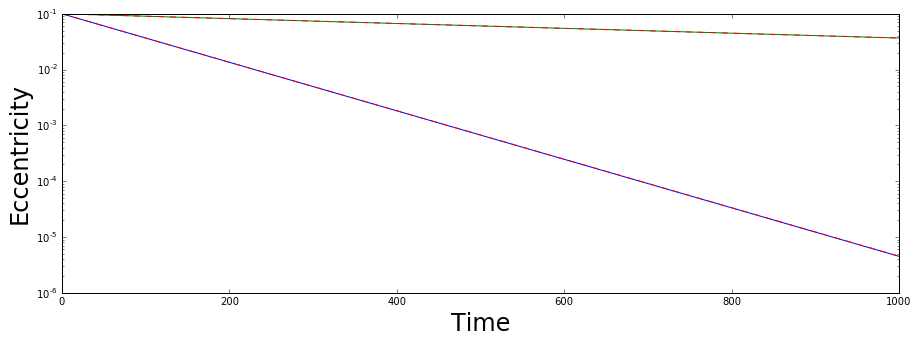

In [5]:
e1pred = [e0*np.e**(t/ps[1].params["tau_e"]) for t in times]
e2pred = [e0*np.e**(t/ps[2].params["tau_e"]) for t in times]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,e1)
plt.plot(times,e1pred, 'r--')
plt.plot(times,e2)
plt.plot(times,e2pred, 'r--')
plt.axes().set_xlabel("Time", fontsize=24)
plt.axes().set_ylabel("Eccentricity", fontsize=24)

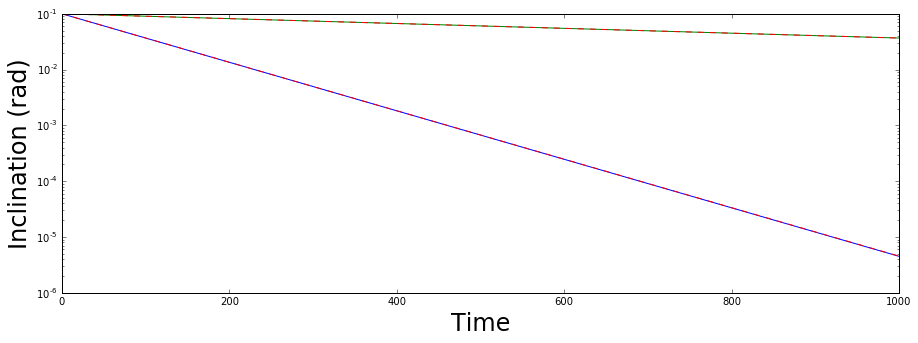

In [6]:
inc1pred = [inc0*np.e**(t/ps[1].params["tau_inc"]) for t in times]
inc2pred = [inc0*np.e**(t/ps[2].params["tau_inc"]) for t in times]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,inc1)
plt.plot(times,inc1pred, 'r--')
plt.plot(times,inc2)
plt.plot(times,inc2pred, 'r--')
plt.axes().set_xlabel("Time", fontsize=24)
plt.axes().set_ylabel("Inclination (rad)", fontsize=24)

**Eccentricity-semimajor axis coupling**

Goldreich & Schlichting (2014) argue that a physical process that induces eccentricity damping should induce semimajor axis damping at order $e^2$, e.g., tides.  We follow the Deck & Batygin (2015) of parametrizing this through a coefficient $p$ that varies between 0 and 1.  p=0 corresponds to no coupling, while p=1 represents the limit of eccentricity damping at constant angular momentum, which to a good approximation is the case with tides (our p=1 therefore corresponds to Golreich and Schlichting's p=3).  We set effect parameters through the effect object returned when we add the effect, which we called `effect` above.  To set p:

In [7]:
mod.params["p"] = 0.7

The default is `p = 0`, i.e., no coupling, so for a single planet, if you don't set `tau_a`, the planet will not migrate.  The current `modify_orbits_forces` implementation always damps eccentricity at constant angular momentum, i.e., p=1 (so you can't set it to an arbitrary value).

**Coordinate Systems**

Everything in REBOUND by default uses Jacobi coordinates.  If you would like to change the reference relative to which the particles are damped:

In [8]:
mod.params["coordinates"] = reboundx.coordinates["BARYCENTRIC"]

to reference orbits to the system's barycenter, or

In [9]:
mod.params["coordinates"] = reboundx.coordinates["PARTICLE"]
ps[0].params["primary"] = 1

to reference orbits to a particular particle (here `sim.particles[0]`)